In [1]:
def Auto_EfficentTemp_MSG_SE_Densenet(vy,vx,upscale,test_size=0.25,if_best_mode='no',modelpath=None,conv_core_num=512,model_deep=5,base_layer=16,simpleconv_deep=3,mbconv_deep=2,se_radio=0.5,if_weight_initialize='no',weight_initialize_method='TruncatedNormal',weight_initialize_parameter1=0.00,weight_initialize_parameter2=0.05,loss_function='default',if_print_model='yes',optimizer='SGD',g_learning_rate=0.001,epochs=2000,batch_size=20,ifrandom_split='yes',ifmute='no',ifsave='no',savepath=None,device='cpu'):
    import tensorflow as tf
    if device=='gpu':
        gpus = tf.config.list_physical_devices('GPU')
        if gpus:
            try:
                # 设置只使用 GPU 0
                tf.config.set_visible_devices(gpus[0], 'GPU')
                # 设置 GPU 0 的内存动态增长
                tf.config.experimental.set_memory_growth(gpus[0], True)
            except RuntimeError as e:
                print(e)
    from keras.models import Sequential,Model
    import math
    from keras.initializers import TruncatedNormal,RandomNormal,RandomUniform
    from keras.layers import BatchNormalization,LayerNormalization,LocallyConnected2D,Conv2D,MaxPooling2D,AveragePooling2D,GlobalAveragePooling2D,Input,UpSampling2D,ZeroPadding2D,UpSampling2D,Add,Flatten,Activation,Dropout,Dense,Concatenate,GlobalAveragePooling2D,Multiply,DepthwiseConv2D
    from sklearn.model_selection import train_test_split
    import numpy as np
    from tensorflow.keras.optimizers import SGD,Adam
    from scipy.stats import pearsonr
    from keras.models import load_model
    import os
    from sklearn.metrics import accuracy_score,log_loss
    import keras.backend as K
        
    vy=np.nan_to_num(vy,nan=0)
    vx=np.nan_to_num(vx,nan=0)
    if ifrandom_split=='yes':
        trainx,testx,trainy,testy = train_test_split(vx,vy,test_size=test_size,random_state=25)
    elif ifrandom_split=='no':
        index=int((1-test_size)*vy.shape[0])
        trainy=vy[:index,:,:,:]
        testy=vy[index:,:,:,:]
        trainx=vx[:index,:,:,:]
        testx=vx[index:,:,:,:]
    if device=='gpu':
        if optimizer == 'SGD':
            g_opt = SGD(lr = g_learning_rate)
        elif optimizer == 'Adam':
            g_opt = Adam(lr = g_learning_rate)
        if if_best_mode=='no':
            def build_generator(trainy,generator_input,model_deep,conv_core_num,upscale,simpleconv_deep,mbconv_deep,se_radio,if_weight_initialize,weight_initialize_parameter1,weight_initialize_parameter2):
                import tensorflow as tf
                from keras.models import Sequential,Model
                import math
                from keras.initializers import TruncatedNormal,RandomNormal,RandomUniform
                from keras.layers import BatchNormalization,LayerNormalization,LocallyConnected2D,Conv2D,MaxPooling2D,AveragePooling2D,GlobalAveragePooling2D,Input,UpSampling2D,ZeroPadding2D,UpSampling2D,Add,Flatten,Activation,Dropout,Dense,Concatenate,GlobalAveragePooling2D,Multiply,DepthwiseConv2D
                from sklearn.model_selection import train_test_split
                import numpy as np
                from tensorflow.keras.optimizers import SGD,Adam
                from scipy.stats import pearsonr
                from keras.models import load_model
                import os
                generator_inputs=Input(shape=(generator_input.shape[1],generator_input.shape[2],vx.shape[3]))
                exec('conv0=Conv2D('+str((4+2*(mbconv_deep-1))*base_layer*(mbconv_deep))+',(3,3),strides=1,padding="same")(generator_inputs)')
                exec('act0=Activation("leaky_relu")(conv0)')
                for i in range(simpleconv_deep):
                    for j in range(2+2*i):
                        if j ==0:
                            if i==0:
                                exec('simpleconv'+str(i+1)+'_'+str(j+1)+'=Conv2D('+str(16*(i+1))+',(3,3),strides=1,padding="same")(act0)')
                            else:
                                exec('simpleconv'+str(i+1)+'_'+str(j+1)+'=Conv2D('+str(16*(i+1))+',(3,3),strides=1,padding="same")(simpleadd'+str(i)+')')
                        else:
                            exec('simpleconv'+str(i+1)+'_'+str(j+1)+'=Conv2D('+str(16*(i+1))+',(3,3),strides=1,padding="same")(simpleact'+str(i+1)+'_'+str(j)+')')
                        exec('simpleact'+str(i+1)+'_'+str(j+1)+'=Activation("leaky_relu")(simpleconv'+str(i+1)+'_'+str(j+1)+')')
                    exec('simpleconv'+str(i+1)+'_last=Conv2D('+str((4+2*(mbconv_deep-1))*base_layer*(mbconv_deep))+',(1,1),strides=1,padding="same")(simpleact'+str(i+1)+'_'+str(j+1)+')')
                    exec('simpleact'+str(i+1)+'_last=Activation("leaky_relu")(simpleconv'+str(i+1)+'_last)')
                    if i==0:
                        exec('simpleadd'+str(i+1)+'=Add()([simpleact'+str(i+1)+'_last,act0])')
                    else:
                        exec('simpleadd'+str(i+1)+'=Add()([simpleact'+str(i+1)+'_last,simpleadd'+str(i)+'])')
                for k in range(mbconv_deep):
                    exec('mbconv'+str(k+1)+'=Conv2D('+str(base_layer*(k+1))+',(1,1),strides=1,padding="same")(simpleadd'+str(i+1)+')')
                    exec('mbact'+str(k+1)+'=Activation("leaky_relu")(mbconv'+str(k+1)+')')
                    for l in range(4+2*k):
                        if l==0:
                            exec('mbdpconv'+str(k+1)+'_'+str(l+1)+'=DepthwiseConv2D((1,1),strides=1,padding="same",depth_multiplier=1)(mbact'+str(k+1)+')')
                        elif l==4+2*k-1:
                            exec('mbdpconv'+str(k+1)+'_'+str(l+1)+'=DepthwiseConv2D((1,1),strides=1,padding="same",depth_multiplier=4)(mbdpact'+str(k+1)+'_'+str(l)+')')
                        else:
                            exec('mbdpconv'+str(k+1)+'_'+str(l+1)+'=DepthwiseConv2D((1,1),strides=1,padding="same",depth_multiplier=1)(mbdpact'+str(k+1)+'_'+str(l)+')')
                        exec('mbdpact'+str(k+1)+'_'+str(l+1)+'=Activation("leaky_relu")(mbdpconv'+str(k+1)+'_'+str(l+1)+')')
                    exec('segap'+str(k+1)+'=GlobalAveragePooling2D()(mbdpact'+str(k+1)+'_'+str(l+1)+')')
                    exec('sefc'+str(k+1)+'_0=Dense('+str(int(4*base_layer*(k+1)*se_radio))+')(segap'+str(k+1)+')')
                    exec('seact'+str(k+1)+'_0=Activation("leaky_relu")(sefc'+str(k+1)+'_0)')
                    exec('sefc'+str(k+1)+'_1=Dense('+str(4*base_layer*(k+1))+')(seact'+str(k+1)+'_0)')
                    exec('seact'+str(k+1)+'_1=Activation("leaky_relu")(sefc'+str(k+1)+'_1)')
                    exec('semulti'+str(k+1)+'=Multiply()([mbdpact'+str(k+1)+'_'+str(l+1)+',seact'+str(k+1)+'_1])')
                    exec('seadd'+str(k+1)+'=Add()([semulti'+str(k+1)+',mbdpact'+str(k+1)+'_'+str(l+1)+'])')
                    exec('mbconv'+str(k+1)+'_last=Conv2D('+str((4+2*(mbconv_deep-1))*base_layer*(mbconv_deep))+',(1,1),strides=1,padding="same")(seadd'+str(k+1)+')')
                    exec('mbact'+str(k+1)+'_last=Activation("leaky_relu")(mbconv'+str(k+1)+'_last)')
                    if k==0:
                        exec('mbconv_add'+str(k+1)+'=Add()([simpleadd'+str(i+1)+',mbact'+str(k+1)+'_last])')
                    else:
                        exec('mbconv_add'+str(k+1)+'=Add()([mbconv_add'+str(k)+',mbact'+str(k+1)+'_last])')
                exec('lastconv_0=Conv2D('+str((4+2*(k))*base_layer*(k+1))+',(1,1),strides=1,padding="same")(mbconv_add'+str(k+1)+')')
                exec('lastact_0=Activation("leaky_relu")(lastconv_0)')
                exec('lastconv_1=Conv2D('+str((4+2*(k))*base_layer*(k+1))+',(1,1),strides=1,padding="same")(lastact_0)')
                exec('lastact_1=Activation("leaky_relu")(lastconv_1)')
                if if_weight_initialize=='no':
                    exec('generator_conv_start_1=Conv2D(conv_core_num,(3,3),strides=1,padding="same")(lastact_1)')
                else:
                    if weight_initialize_method=='RandomNormal':
                        exec('generator_conv_start_1=Conv2D(conv_core_num,(3,3),strides=1,padding="same",kernel_initializer = RandomNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(lastact_1)')
                    elif weight_initialize_method=='RandomUniform':
                        exec('generator_conv_start_1=Conv2D(conv_core_num,(3,3),strides=1,padding="same",kernel_initializer = RandomUniform(minval=weight_initialize_parameter1,maxval=weight_initialize_parameter2))(lastact_1)')
                    elif weight_initialize_method=='TruncatedNormal':
                        exec('generator_conv_start_1=Conv2D(conv_core_num,(3,3),strides=1,padding="same",kernel_initializer = TruncatedNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(lastact_1)')
                exec('generator_act_start_1=Activation("leaky_relu")(generator_conv_start_1)')
                if if_weight_initialize=='no':
                    exec('generator_conv_start_2=Conv2D(conv_core_num,(3,3),strides=1,padding="same")(generator_act_start_1)')
                else:
                    if weight_initialize_method=='RandomNormal':
                        exec('generator_conv_start_2=Conv2D(conv_core_num,(3,3),strides=1,padding="same",kernel_initializer = RandomNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(generator_act_start_1)')
                    elif weight_initialize_method=='RandomUniform':
                        exec('generator_conv_start_2=Conv2D(conv_core_num,(3,3),strides=1,padding="same",kernel_initializer = RandomUniform(minval=weight_initialize_parameter1,maxval=weight_initialize_parameter2))(generator_act_start_1)')
                    elif weight_initialize_method=='TruncatedNormal':
                        exec('generator_conv_start_2=Conv2D(conv_core_num,(3,3),strides=1,padding="same",kernel_initializer = TruncatedNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(generator_act_start_1)')
                exec('generator_act_start_2=Activation("leaky_relu")(generator_conv_start_2)')
                exec('segap_start=GlobalAveragePooling2D()(generator_act_start_2)')
                exec('sefc_start_1=Dense(int(conv_core_num*se_radio))(segap_start)')
                exec('seact_start_1=Activation("leaky_relu")(sefc_start_1)')
                exec('sefc_start_2=Dense(conv_core_num)(seact_start_1)')
                exec('seact_start_2=Activation("leaky_relu")(sefc_start_2)')
                exec('semulti_start=Multiply()([generator_act_start_2,seact_start_2])')
                exec('seadd_start=Add()([semulti_start,generator_act_start_2])')
                for i in range(model_deep):
                    if i==0:
                        exec('generator_upsample_'+str(i+1)+'=UpSampling2D(size=(upscale,upscale))(seadd_start)')
                    else:
                        exec('generator_upsample_'+str(i+1)+'=UpSampling2D(size=(upscale,upscale))(generator_act'+str(i)+'_2)')             
                    if if_weight_initialize=='no':
                        exec('generator_conv'+str(i+1)+'_1=Conv2D(int(conv_core_num/(2**(i+1))),(3,3),strides=1,padding="same")(generator_upsample_'+str(i+1)+')')
                    else:
                        if weight_initialize_method=='RandomNormal':
                            exec('generator_conv'+str(i+1)+'_1=Conv2D(int(conv_core_num/(2**(i+1))),(3,3),strides=1,padding="same",kernel_initializer = RandomNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(generator_upsample_'+str(i+1)+')')
                        elif weight_initialize_method=='RandomUniform':
                            exec('generator_conv'+str(i+1)+'_1=Conv2D(int(conv_core_num/(2**(i+1))),(3,3),strides=1,padding="same",kernel_initializer = RandomUniform(minval=weight_initialize_parameter1,maxval=weight_initialize_parameter2))(generator_upsample_'+str(i+1)+')')
                        elif weight_initialize_method=='TruncatedNormal':
                            exec('generator_conv'+str(i+1)+'_1=Conv2D(int(conv_core_num/(2**(i+1))),(3,3),strides=1,padding="same",kernel_initializer = TruncatedNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(generator_upsample_'+str(i+1)+')')
                    exec('generator_act'+str(i+1)+'_1=Activation("leaky_relu")(generator_conv'+str(i+1)+'_1)')
                    if if_weight_initialize=='no':
                        exec('generator_conv'+str(i+1)+'_2=Conv2D(int(conv_core_num/(2**(i+1))),(3,3),strides=1,padding="same")(generator_act'+str(i+1)+'_1)')
                    else:
                        if weight_initialize_method=='RandomNormal':
                            exec('generator_conv'+str(i+1)+'_2=Conv2D(int(conv_core_num/(2**(i+1))),(3,3),strides=1,padding="same",kernel_initializer = RandomNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(generator_act'+str(i+1)+'_1)')
                        elif weight_initialize_method=='RandomUniform':
                            exec('generator_conv'+str(i+1)+'_2=Conv2D(int(conv_core_num/(2**(i+1))),(3,3),strides=1,padding="same",kernel_initializer = RandomUniform(minval=weight_initialize_parameter1,maxval=weight_initialize_parameter2))(generator_act'+str(i+1)+'_1)')
                        elif weight_initialize_method=='TruncatedNormal':
                            exec('generator_conv'+str(i+1)+'_2=Conv2D(int(conv_core_num/(2**(i+1))),(3,3),strides=1,padding="same",kernel_initializer = TruncatedNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(generator_act'+str(i+1)+'_1)')
                    exec('generator_act'+str(i+1)+'_2=Activation("leaky_relu")(generator_conv'+str(i+1)+'_2)')
                if if_weight_initialize=='no':
                    generator_output=eval('Conv2D(trainy.shape[3],(1,1),strides=1,padding="same")(generator_act'+str(i+1)+'_2)')
                else:
                    if weight_initialize_method=='RandomNormal':
                        generator_output=eval('Conv2D(trainy.shape[3],(1,1),strides=1,padding="same",kernel_initializer = RandomNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(generator_act'+str(i+1)+'_2)')
                    elif weight_initialize_method=='RandomUniform':
                        generator_output=eval('Conv2D(trainy.shape[3],(1,1),strides=1,padding="same",kernel_initializer = RandomUniform(minval=weight_initialize_parameter1,maxval=weight_initialize_parameter2))(generator_act'+str(i+1)+'_2)')
                    elif weight_initialize_method=='TruncatedNormal':
                        generator_output=eval('Conv2D(trainy.shape[3],(1,1),strides=1,padding="same",kernel_initializer = TruncatedNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(generator_act'+str(i+1)+'_2)')
                
                return Model(inputs=generator_inputs, outputs=generator_output)
            generator=build_generator(trainy,trainx,model_deep,conv_core_num,upscale,simpleconv_deep,mbconv_deep,se_radio,if_weight_initialize,weight_initialize_parameter1,weight_initialize_parameter2)
            generator_outputs=generator(trainx[0].reshape(1,trainx.shape[1],trainx.shape[2],trainx.shape[3]))
        else:
            generator=load_model(modelpath+'_generator',compile=False)
        def generator_loss(y_true,y_pred):
            import tensorflow as tf
            
            y_true=tf.cast(y_true,dtype=tf.float32)
            y_pred=tf.cast(y_pred,dtype=tf.float32)
            y_true_mean=tf.reduce_mean(y_true,axis=0)
            y_pred_mean=tf.reduce_mean(y_pred,axis=0)
            cov=tf.reduce_sum((y_true-y_true_mean)*(y_pred-y_pred_mean),axis=0)
            y_true_v=tf.reduce_sum(tf.square((y_true-y_true_mean)),axis=0)
            y_pred_v=tf.reduce_sum(tf.square((y_pred-y_pred_mean)),axis=0)
            y_true_v=tf.sqrt(y_true_v)
            y_pred_v=tf.sqrt(y_pred_v)
            pearson=tf.reduce_mean(cov/(y_true_v*y_pred_v))
            mae=tf.keras.losses.MeanAbsoluteError()
            mae_loss=tf.reduce_mean(mae(y_true,y_pred))
            y_true_ssim=(y_true-tf.reduce_min(y_true))/(tf.reduce_max(y_true)-tf.reduce_min(y_true))
            y_pred_ssim=(y_pred-tf.reduce_min(y_pred))/(tf.reduce_max(y_pred)-tf.reduce_min(y_pred))
            ssim_loss=tf.reduce_mean(tf.image.ssim(y_pred_ssim,y_true_ssim,max_val=1.0))
            psnr_loss=tf.reduce_mean(tf.image.psnr(y_pred_ssim,y_true_ssim,max_val=1.0))
            if loss_function=='default' or loss_function=='SSIM':
                return (1-ssim_loss)+0.01*mae_loss
            elif loss_function=='Pearson':
                return (1-pearson)+0.01*mae_loss
            elif loss_function=='PSNR':
                return (1-psnr_loss/100.0)+0.01*mae_loss
        def generator_metrics(y_true,y_pred):
            import tensorflow as tf
            y_true=tf.cast(y_true,dtype=tf.float32)
            y_pred=tf.cast(y_pred,dtype=tf.float32)
            y_true_mean=tf.reduce_mean(y_true,axis=0)
            y_pred_mean=tf.reduce_mean(y_pred,axis=0)
            cov=tf.reduce_sum((y_true-y_true_mean)*(y_pred-y_pred_mean),axis=0)
            y_true_v=tf.reduce_sum(tf.square((y_true-y_true_mean)),axis=0)
            y_pred_v=tf.reduce_sum(tf.square((y_pred-y_pred_mean)),axis=0)
            y_true_v=tf.sqrt(y_true_v)
            y_pred_v=tf.sqrt(y_pred_v)
            pearson=tf.reduce_mean(cov/(y_true_v*y_pred_v))
            return pearson
        generator.compile(loss=generator_loss,optimizer=g_opt,metrics=generator_metrics)
        if if_print_model=='yes':
            print(generator.summary())
        def train(epochs,trainx,trainy,generator):
            for i in range(epochs):
                g_loss_tests=np.zeros((int(testy.shape[0]/batch_size)))
                g_pearson_tests=np.zeros((int(testy.shape[0]/batch_size)))
                for j in range(0, trainy.shape[0], batch_size):
                    if j+batch_size<trainy.shape[0]:
                        batch_trainx = trainx[j:j + batch_size]
                        batch_trainy = trainy[j:j + batch_size]
                        g_loss_train=generator.train_on_batch(batch_trainx,batch_trainy)
                for k in range(0,testy.shape[0],batch_size):
                    if k+batch_size<testy.shape[0]:
                        batch_testx = testx[k:k + batch_size]
                        batch_testy = testy[k:k + batch_size]
                        generator_predict=generator.predict(batch_testx,verbose=0)
                        g_loss_tests[int(k/batch_size)]=generator_loss(batch_testy,generator_predict)
                        g_pearson_tests[int(k/batch_size)]=generator_metrics(batch_testy,generator_predict)
                g_loss_test=np.nanmean(g_loss_tests)
                g_pearson_test=np.nanmean(g_pearson_tests)
                if ifmute=='no':
                    print('第',i+1,'次训练','G loss_train:',g_loss_train[0],'G pearson_train:',g_loss_train[1])
                    print('第',i+1,'次测试','G loss_test:',np.array(g_loss_test),'G pearson_test:',np.array(g_pearson_test))
                if ifsave=='every':
                    generator.save(savepath+'_generator_'+str(i+1))
        train(epochs,trainx,trainy,generator)
        predicty=np.array(generator.predict(testx)).reshape(testy.shape[0],testy.shape[1],testy.shape[2],testy.shape[3])
        r=np.zeros((testy.shape[1],testy.shape[2],testy.shape[3]))
        p=np.zeros((testy.shape[1],testy.shape[2],testy.shape[3]))
        for i in range(testy.shape[1]):
            for j in range(testy.shape[2]):
                for k in range(testy.shape[3]):
                    r[i,j,k],p[i,j,k]=pearsonr(predicty[:,i,j,k],testy[:,i,j,k])
        print('相关系数',np.nanmean(r,axis=(0,1)))
        if ifsave=='yes':
            generator.save(savepath+'_generator')
    else:
        os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
        with tf.device('/cpu:0'):
            if optimizer == 'SGD':
                g_opt = SGD(lr = g_learning_rate)
            elif optimizer == 'Adam':
                g_opt = Adam(lr = g_learning_rate)
            if if_best_mode=='no':
                def build_generator(trainy,generator_input,model_deep,conv_core_num,upscale,simpleconv_deep,mbconv_deep,se_radio,if_weight_initialize,weight_initialize_parameter1,weight_initialize_parameter2):
                    import tensorflow as tf
                    from keras.models import Sequential,Model
                    import math
                    from keras.initializers import TruncatedNormal,RandomNormal,RandomUniform
                    from keras.layers import BatchNormalization,LayerNormalization,LocallyConnected2D,Conv2D,MaxPooling2D,AveragePooling2D,GlobalAveragePooling2D,Input,UpSampling2D,ZeroPadding2D,UpSampling2D,Add,Flatten,Activation,Dropout,Dense,Concatenate,GlobalAveragePooling2D,Multiply,DepthwiseConv2D
                    from sklearn.model_selection import train_test_split
                    import numpy as np
                    from tensorflow.keras.optimizers import SGD,Adam
                    from scipy.stats import pearsonr
                    from keras.models import load_model
                    import os
                    generator_inputs=Input(shape=(generator_input.shape[1],generator_input.shape[2],vx.shape[3]))
                    exec('conv0=Conv2D('+str((4+2*(mbconv_deep-1))*base_layer*(mbconv_deep))+',(3,3),strides=1,padding="same")(generator_inputs)')
                    exec('act0=Activation("leaky_relu")(conv0)')
                    for i in range(simpleconv_deep):
                        for j in range(2+2*i):
                            if j ==0:
                                if i==0:
                                    exec('simpleconv'+str(i+1)+'_'+str(j+1)+'=Conv2D('+str(16*(i+1))+',(3,3),strides=1,padding="same")(act0)')
                                else:
                                    exec('simpleconv'+str(i+1)+'_'+str(j+1)+'=Conv2D('+str(16*(i+1))+',(3,3),strides=1,padding="same")(simpleadd'+str(i)+')')
                            else:
                                exec('simpleconv'+str(i+1)+'_'+str(j+1)+'=Conv2D('+str(16*(i+1))+',(3,3),strides=1,padding="same")(simpleact'+str(i+1)+'_'+str(j)+')')
                            exec('simpleact'+str(i+1)+'_'+str(j+1)+'=Activation("leaky_relu")(simpleconv'+str(i+1)+'_'+str(j+1)+')')
                        exec('simpleconv'+str(i+1)+'_last=Conv2D('+str((4+2*(mbconv_deep-1))*base_layer*(mbconv_deep))+',(1,1),strides=1,padding="same")(simpleact'+str(i+1)+'_'+str(j+1)+')')
                        exec('simpleact'+str(i+1)+'_last=Activation("leaky_relu")(simpleconv'+str(i+1)+'_last)')
                        if i==0:
                            exec('simpleadd'+str(i+1)+'=Add()([simpleact'+str(i+1)+'_last,act0])')
                        else:
                            exec('simpleadd'+str(i+1)+'=Add()([simpleact'+str(i+1)+'_last,simpleadd'+str(i)+'])')
                    for k in range(mbconv_deep):
                        exec('mbconv'+str(k+1)+'=Conv2D('+str(base_layer*(k+1))+',(1,1),strides=1,padding="same")(simpleadd'+str(i+1)+')')
                        exec('mbact'+str(k+1)+'=Activation("leaky_relu")(mbconv'+str(k+1)+')')
                        for l in range(4+2*k):
                            if l==0:
                                exec('mbdpconv'+str(k+1)+'_'+str(l+1)+'=DepthwiseConv2D((1,1),strides=1,padding="same",depth_multiplier=1)(mbact'+str(k+1)+')')
                            elif l==4+2*k-1:
                                exec('mbdpconv'+str(k+1)+'_'+str(l+1)+'=DepthwiseConv2D((1,1),strides=1,padding="same",depth_multiplier=4)(mbdpact'+str(k+1)+'_'+str(l)+')')
                            else:
                                exec('mbdpconv'+str(k+1)+'_'+str(l+1)+'=DepthwiseConv2D((1,1),strides=1,padding="same",depth_multiplier=1)(mbdpact'+str(k+1)+'_'+str(l)+')')
                            exec('mbdpact'+str(k+1)+'_'+str(l+1)+'=Activation("leaky_relu")(mbdpconv'+str(k+1)+'_'+str(l+1)+')')
                        exec('segap'+str(k+1)+'=GlobalAveragePooling2D()(mbdpact'+str(k+1)+'_'+str(l+1)+')')
                        exec('sefc'+str(k+1)+'_0=Dense('+str(int(4*base_layer*(k+1)*se_radio))+')(segap'+str(k+1)+')')
                        exec('seact'+str(k+1)+'_0=Activation("leaky_relu")(sefc'+str(k+1)+'_0)')
                        exec('sefc'+str(k+1)+'_1=Dense('+str(4*base_layer*(k+1))+')(seact'+str(k+1)+'_0)')
                        exec('seact'+str(k+1)+'_1=Activation("leaky_relu")(sefc'+str(k+1)+'_1)')
                        exec('semulti'+str(k+1)+'=Multiply()([mbdpact'+str(k+1)+'_'+str(l+1)+',seact'+str(k+1)+'_1])')
                        exec('seadd'+str(k+1)+'=Add()([semulti'+str(k+1)+',mbdpact'+str(k+1)+'_'+str(l+1)+'])')
                        exec('mbconv'+str(k+1)+'_last=Conv2D('+str((4+2*(mbconv_deep-1))*base_layer*(mbconv_deep))+',(1,1),strides=1,padding="same")(seadd'+str(k+1)+')')
                        exec('mbact'+str(k+1)+'_last=Activation("leaky_relu")(mbconv'+str(k+1)+'_last)')
                        if k==0:
                            exec('mbconv_add'+str(k+1)+'=Add()([simpleadd'+str(i+1)+',mbact'+str(k+1)+'_last])')
                        else:
                            exec('mbconv_add'+str(k+1)+'=Add()([mbconv_add'+str(k)+',mbact'+str(k+1)+'_last])')
                    exec('lastconv_0=Conv2D('+str((4+2*(k))*base_layer*(k+1))+',(1,1),strides=1,padding="same")(mbconv_add'+str(k+1)+')')
                    exec('lastact_0=Activation("leaky_relu")(lastconv_0)')
                    exec('lastconv_1=Conv2D('+str((4+2*(k))*base_layer*(k+1))+',(1,1),strides=1,padding="same")(lastact_0)')
                    exec('lastact_1=Activation("leaky_relu")(lastconv_1)')
                    if if_weight_initialize=='no':
                        exec('generator_conv_start_1=Conv2D(conv_core_num,(3,3),strides=1,padding="same")(lastact_1)')
                    else:
                        if weight_initialize_method=='RandomNormal':
                            exec('generator_conv_start_1=Conv2D(conv_core_num,(3,3),strides=1,padding="same",kernel_initializer = RandomNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(lastact_1)')
                        elif weight_initialize_method=='RandomUniform':
                            exec('generator_conv_start_1=Conv2D(conv_core_num,(3,3),strides=1,padding="same",kernel_initializer = RandomUniform(minval=weight_initialize_parameter1,maxval=weight_initialize_parameter2))(lastact_1)')
                        elif weight_initialize_method=='TruncatedNormal':
                            exec('generator_conv_start_1=Conv2D(conv_core_num,(3,3),strides=1,padding="same",kernel_initializer = TruncatedNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(lastact_1)')
                    exec('generator_act_start_1=Activation("leaky_relu")(generator_conv_start_1)')
                    if if_weight_initialize=='no':
                        exec('generator_conv_start_2=Conv2D(conv_core_num,(3,3),strides=1,padding="same")(generator_act_start_1)')
                    else:
                        if weight_initialize_method=='RandomNormal':
                            exec('generator_conv_start_2=Conv2D(conv_core_num,(3,3),strides=1,padding="same",kernel_initializer = RandomNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(generator_act_start_1)')
                        elif weight_initialize_method=='RandomUniform':
                            exec('generator_conv_start_2=Conv2D(conv_core_num,(3,3),strides=1,padding="same",kernel_initializer = RandomUniform(minval=weight_initialize_parameter1,maxval=weight_initialize_parameter2))(generator_act_start_1)')
                        elif weight_initialize_method=='TruncatedNormal':
                            exec('generator_conv_start_2=Conv2D(conv_core_num,(3,3),strides=1,padding="same",kernel_initializer = TruncatedNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(generator_act_start_1)')
                    exec('generator_act_start_2=Activation("leaky_relu")(generator_conv_start_2)')
                    exec('segap_start=GlobalAveragePooling2D()(generator_act_start_2)')
                    exec('sefc_start_1=Dense(int(conv_core_num*se_radio))(segap_start)')
                    exec('seact_start_1=Activation("leaky_relu")(sefc_start_1)')
                    exec('sefc_start_2=Dense(conv_core_num)(seact_start_1)')
                    exec('seact_start_2=Activation("leaky_relu")(sefc_start_2)')
                    exec('semulti_start=Multiply()([generator_act_start_2,seact_start_2])')
                    exec('seadd_start=Add()([semulti_start,generator_act_start_2])')
                    for i in range(model_deep):
                        if i==0:
                            exec('generator_upsample_'+str(i+1)+'=UpSampling2D(size=(upscale,upscale))(seadd_start)')
                        else:
                            exec('generator_upsample_'+str(i+1)+'=UpSampling2D(size=(upscale,upscale))(generator_act'+str(i)+'_2)')             
                        if if_weight_initialize=='no':
                            exec('generator_conv'+str(i+1)+'_1=Conv2D(int(conv_core_num/(2**(i+1))),(3,3),strides=1,padding="same")(generator_upsample_'+str(i+1)+')')
                        else:
                            if weight_initialize_method=='RandomNormal':
                                exec('generator_conv'+str(i+1)+'_1=Conv2D(int(conv_core_num/(2**(i+1))),(3,3),strides=1,padding="same",kernel_initializer = RandomNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(generator_upsample_'+str(i+1)+')')
                            elif weight_initialize_method=='RandomUniform':
                                exec('generator_conv'+str(i+1)+'_1=Conv2D(int(conv_core_num/(2**(i+1))),(3,3),strides=1,padding="same",kernel_initializer = RandomUniform(minval=weight_initialize_parameter1,maxval=weight_initialize_parameter2))(generator_upsample_'+str(i+1)+')')
                            elif weight_initialize_method=='TruncatedNormal':
                                exec('generator_conv'+str(i+1)+'_1=Conv2D(int(conv_core_num/(2**(i+1))),(3,3),strides=1,padding="same",kernel_initializer = TruncatedNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(generator_upsample_'+str(i+1)+')')
                        exec('generator_act'+str(i+1)+'_1=Activation("leaky_relu")(generator_conv'+str(i+1)+'_1)')
                        if if_weight_initialize=='no':
                            exec('generator_conv'+str(i+1)+'_2=Conv2D(int(conv_core_num/(2**(i+1))),(3,3),strides=1,padding="same")(generator_act'+str(i+1)+'_1)')
                        else:
                            if weight_initialize_method=='RandomNormal':
                                exec('generator_conv'+str(i+1)+'_2=Conv2D(int(conv_core_num/(2**(i+1))),(3,3),strides=1,padding="same",kernel_initializer = RandomNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(generator_act'+str(i+1)+'_1)')
                            elif weight_initialize_method=='RandomUniform':
                                exec('generator_conv'+str(i+1)+'_2=Conv2D(int(conv_core_num/(2**(i+1))),(3,3),strides=1,padding="same",kernel_initializer = RandomUniform(minval=weight_initialize_parameter1,maxval=weight_initialize_parameter2))(generator_act'+str(i+1)+'_1)')
                            elif weight_initialize_method=='TruncatedNormal':
                                exec('generator_conv'+str(i+1)+'_2=Conv2D(int(conv_core_num/(2**(i+1))),(3,3),strides=1,padding="same",kernel_initializer = TruncatedNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(generator_act'+str(i+1)+'_1)')
                        exec('generator_act'+str(i+1)+'_2=Activation("leaky_relu")(generator_conv'+str(i+1)+'_2)')
                    if if_weight_initialize=='no':
                        generator_output=eval('Conv2D(trainy.shape[3],(1,1),strides=1,padding="same")(generator_act'+str(i+1)+'_2)')
                    else:
                        if weight_initialize_method=='RandomNormal':
                            generator_output=eval('Conv2D(trainy.shape[3],(1,1),strides=1,padding="same",kernel_initializer = RandomNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(generator_act'+str(i+1)+'_2)')
                        elif weight_initialize_method=='RandomUniform':
                            generator_output=eval('Conv2D(trainy.shape[3],(1,1),strides=1,padding="same",kernel_initializer = RandomUniform(minval=weight_initialize_parameter1,maxval=weight_initialize_parameter2))(generator_act'+str(i+1)+'_2)')
                        elif weight_initialize_method=='TruncatedNormal':
                            generator_output=eval('Conv2D(trainy.shape[3],(1,1),strides=1,padding="same",kernel_initializer = TruncatedNormal(mean=weight_initialize_parameter1,stddev=weight_initialize_parameter2))(generator_act'+str(i+1)+'_2)')
                    
                    return Model(inputs=generator_inputs, outputs=generator_output)
                generator=build_generator(trainy,trainx,model_deep,conv_core_num,upscale,simpleconv_deep,mbconv_deep,se_radio,if_weight_initialize,weight_initialize_parameter1,weight_initialize_parameter2)
                generator_outputs=generator(trainx[0].reshape(1,trainx.shape[1],trainx.shape[2],trainx.shape[3]))
            else:
                generator=load_model(modelpath+'_generator',compile=False)
            def generator_loss(y_true,y_pred):
                import tensorflow as tf
                
                y_true=tf.cast(y_true,dtype=tf.float32)
                y_pred=tf.cast(y_pred,dtype=tf.float32)
                y_true_mean=tf.reduce_mean(y_true,axis=0)
                y_pred_mean=tf.reduce_mean(y_pred,axis=0)
                cov=tf.reduce_sum((y_true-y_true_mean)*(y_pred-y_pred_mean),axis=0)
                y_true_v=tf.reduce_sum(tf.square((y_true-y_true_mean)),axis=0)
                y_pred_v=tf.reduce_sum(tf.square((y_pred-y_pred_mean)),axis=0)
                y_true_v=tf.sqrt(y_true_v)
                y_pred_v=tf.sqrt(y_pred_v)
                pearson=tf.reduce_mean(cov/(y_true_v*y_pred_v))
                mae=tf.keras.losses.MeanAbsoluteError()
                mae_loss=tf.reduce_mean(mae(y_true,y_pred))
                y_true_ssim=(y_true-tf.reduce_min(y_true))/(tf.reduce_max(y_true)-tf.reduce_min(y_true))
                y_pred_ssim=(y_pred-tf.reduce_min(y_pred))/(tf.reduce_max(y_pred)-tf.reduce_min(y_pred))
                ssim_loss=tf.reduce_mean(tf.image.ssim(y_pred_ssim,y_true_ssim,max_val=1.0))
                psnr_loss=tf.reduce_mean(tf.image.psnr(y_pred_ssim,y_true_ssim,max_val=1.0))
                if loss_function=='default' or loss_function=='SSIM':
                    return (1-ssim_loss)+0.01*mae_loss
                elif loss_function=='Pearson':
                    return (1-pearson)+0.01*mae_loss
                elif loss_function=='PSNR':
                    return (1-psnr_loss/100.0)+0.01*mae_loss
            def generator_metrics(y_true,y_pred):
                import tensorflow as tf
                y_true=tf.cast(y_true,dtype=tf.float32)
                y_pred=tf.cast(y_pred,dtype=tf.float32)
                y_true_mean=tf.reduce_mean(y_true,axis=0)
                y_pred_mean=tf.reduce_mean(y_pred,axis=0)
                cov=tf.reduce_sum((y_true-y_true_mean)*(y_pred-y_pred_mean),axis=0)
                y_true_v=tf.reduce_sum(tf.square((y_true-y_true_mean)),axis=0)
                y_pred_v=tf.reduce_sum(tf.square((y_pred-y_pred_mean)),axis=0)
                y_true_v=tf.sqrt(y_true_v)
                y_pred_v=tf.sqrt(y_pred_v)
                pearson=tf.reduce_mean(cov/(y_true_v*y_pred_v))
                return pearson
            generator.compile(loss=generator_loss,optimizer=g_opt,metrics=generator_metrics)
            if if_print_model=='yes':
                print(generator.summary())
            def train(epochs,trainx,trainy,generator):
                for i in range(epochs):
                    g_loss_tests=np.zeros((int(testy.shape[0]/batch_size)))
                    g_pearson_tests=np.zeros((int(testy.shape[0]/batch_size)))
                    for j in range(0, trainy.shape[0], batch_size):
                        if j+batch_size<trainy.shape[0]:
                            batch_trainx = trainx[j:j + batch_size]
                            batch_trainy = trainy[j:j + batch_size]
                            g_loss_train=generator.train_on_batch(batch_trainx,batch_trainy)
                    for k in range(0,testy.shape[0],batch_size):
                        if k+batch_size<testy.shape[0]:
                            batch_testx = testx[k:k + batch_size]
                            batch_testy = testy[k:k + batch_size]
                            generator_predict=generator.predict(batch_testx,verbose=0)
                            g_loss_tests[int(k/batch_size)]=generator_loss(batch_testy,generator_predict)
                            g_pearson_tests[int(k/batch_size)]=generator_metrics(batch_testy,generator_predict)
                    g_loss_test=np.nanmean(g_loss_tests)
                    g_pearson_test=np.nanmean(g_pearson_tests)
                    if ifmute=='no':
                        print('第',i+1,'次训练','G loss_train:',g_loss_train[0],'G pearson_train:',g_loss_train[1])
                        print('第',i+1,'次测试','G loss_test:',np.array(g_loss_test),'G pearson_test:',np.array(g_pearson_test))
                    if ifsave=='every':
                        generator.save(savepath+'_generator_'+str(i+1))
            train(epochs,trainx,trainy,generator)
            predicty=np.array(generator.predict(testx)).reshape(testy.shape[0],testy.shape[1],testy.shape[2],testy.shape[3])
            r=np.zeros((testy.shape[1],testy.shape[2],testy.shape[3]))
            p=np.zeros((testy.shape[1],testy.shape[2],testy.shape[3]))
            for i in range(testy.shape[1]):
                for j in range(testy.shape[2]):
                    for k in range(testy.shape[3]):
                        r[i,j,k],p[i,j,k]=pearsonr(predicty[:,i,j,k],testy[:,i,j,k])
            print('相关系数',np.nanmean(r,axis=(0,1)))
            if ifsave=='yes':
                generator.save(savepath+'_generator')
    return generator,predicty,testy,r,p

In [2]:
#打开nc文件
def open_data_nc(ncmode,filename,v_name,iftime,timename,timestart,timeend,iflon,lonname,iflat,latname,latlow,lattop,lonleft,lonright,latresolution,lonresolution,ifexper,iflevel,levelname,level,changeresolution=1,timespace=1,ifchange_west_east='no',ifinterpolate='no'):
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from netCDF4 import Dataset as net
    import xarray as xr
    from datetime import datetime,timedelta
    from dateutil.relativedelta import relativedelta
    import os
    #from wrf import getvar,interplevel
    
    plt.rcParams['font.sans-serif']=['SimHei'] #正常显示中文
    plt.rcParams['axes.unicode_minus']=False #正常显示正负号
    if ncmode == 'one':
        file = xr.open_dataset(filename)
        if ifinterpolate == 'yes':
            inter = str('file.interp('+latname+'=np.arange('+str(latlow)+','+str(lattop+latresolution)+','+str(latresolution)+'),'+lonname+'=np.arange('+str(lonleft)+','+str(lonright+lonresolution)+','+str(lonresolution)+'))')
            files=eval(inter)
            file = files
        if iftime  == 'yes' or iftime == 'self':
            times = np.array(file[timename])
        if iflon == 'yes':
            lon = np.array(file[lonname])
        if iflat == 'yes':
            lat = np.array(file[latname])
        v = file[v_name]
        if iflevel != 'no':
            levels = np.array(file[levelname])
    elif ncmode == 'more_time' or ncmode =='more_level':
        direc = os.listdir(filename)
        path = []
        file = []
        v = []
        lat = []
        lon = []
        times = []
        levels = []
        for i in range(len(direc)):
            if filename[-1] == '/':  
                path.append(filename+str(direc[i]))
            else:
                path.append(filename+'/'+str(direc[i]))
            file_xr = xr.open_dataset(path[i])
            if ifinterpolate == 'yes':
                inter = str('file_xr.interp('+latname+'=np.arange('+str(latlow)+','+str(lattop)+','+str(latresolution)+'),'+lonname+'=np.arange('+str(lonleft)+','+str(lonright)+','+str(lonresolution)+'))')
                files=eval(inter)
                file_xr = files
            file.append(file_xr)
            if ncmode == 'more_time':
                vs=np.array(file[i][v_name])
                if iftime =='yes':
                    timelist=np.array(file[i][timename])
                if i != 0:
                    if iftime =='yes':
                        v=np.concatenate((v,vs))
                        times=np.concatenate((times,timelist))
                    elif iftime =='create':
                        if iflevel !='no':
                            if iflat !='no':
                                if iflon !='no':
                                    vs = vs.reshape((1,vs.shape[0],vs.shape[1],vs.shape[2]))
                                else:
                                    vs = vs.reshape((1,vs.shape[0],vs.shape[1]))
                            else:
                                if iflon !='no':
                                    vs = vs.reshape((1,vs.shape[0],vs.shape[1]))
                                else:
                                    vs = vs.reshape((1,vs.shape[0]))
                        else:
                            if iflat !='no':
                                if iflon !='no':
                                    vs = vs.reshape((1,vs.shape[0],vs.shape[1]))
                                else:
                                    vs = vs.reshape((1,vs.shape[0]))
                            else:
                                if iflon !='no':
                                    vs = vs.reshape((1,vs.shape[0]))
                                else:
                                    vs = vs.reshape((1))
                        v=np.concatenate((v,vs))
                else:
                    if iftime == 'create':
                        if iflevel !='no':
                            if iflat !='no':
                                if iflon !='no':
                                    vs = vs.reshape((1,vs.shape[0],vs.shape[1],vs.shape[2]))
                                else:
                                    vs = vs.reshape((1,vs.shape[0],vs.shape[1]))
                            else:
                                if iflon !='no':
                                    vs = vs.reshape((1,vs.shape[0],vs.shape[1]))
                                else:
                                    vs = vs.reshape((1,vs.shape[0]))
                        else:
                            if iflat !='no':
                                if iflon !='no':
                                    vs = vs.reshape((1,vs.shape[0],vs.shape[1]))
                                else:
                                    vs = vs.reshape((1,vs.shape[0]))
                            else:
                                if iflon !='no':
                                    vs = vs.reshape((1,vs.shape[0]))
                                else:
                                    vs = vs.reshape((1))
                        v=vs
                    elif iftime == 'yes':
                        v = vs
                        times=timelist
            if ncmode == 'more_level':
                if iflevel == 'create':
                    vs=np.array(file[i][v_name])
                    levels=level
                elif iflevel == 'yes' or iflevel =='all' or iflevel =='self' or iflevel =='selfchose':
                    if iftime !='no':
                        if iflat !='no':
                            if iflon !='no':
                                vs=np.array(file[i][v_name]).transpose(1,0,2,3)
                            else:
                                vs=np.array(file[i][v_name]).transpose(1,0,2)
                        else:
                            if iflon !='no':
                                vs=np.array(file[i][v_name]).transpose(1,0,2)
                            else:
                                vs=np.array(file[i][v_name]).transpose(1,0)
                    levellist=np.array(file[i][levelname])      
                if i != 0:
                    if iflevel == 'yes' or iflevel =='all' or iflevel =='self' or iflevel =='selfchose':
                        v=np.concatenate((v,vs))
                        levels=np.concatenate((levels,levellist))
                    elif iflevel =='create':
                        if iftime !='no':
                            if iflat !='no':
                                if iflon !='no':
                                    vs = vs.reshape((1,vs.shape[0],vs.shape[1],vs.shape[2]))
                                else:
                                    vs = vs.reshape((1,vs.shape[0],vs.shape[1]))
                            else:
                                if iflon !='no':
                                    vs = vs.reshape((1,vs.shape[0],vs.shape[1]))
                                else:
                                    vs = vs.reshape((1,vs.shape[0]))
                        else:
                            if iflat !='no':
                                if iflon !='no':
                                    vs = vs.reshape((1,vs.shape[0],vs.shape[1]))
                                else:
                                    vs = vs.reshape((1,vs.shape[0]))
                            else:
                                if iflon !='no':
                                    vs = vs.reshape((1,vs.shape[0]))
                                else:
                                    vs = vs.reshape((1))
                        v=np.concatenate((v,vs))
                else:
                    if iflevel == 'create':
                        if iftime !='no':
                            if iflat !='no':
                                if iflon !='no':
                                    vs = vs.reshape((1,vs.shape[0],vs.shape[1],vs.shape[2]))
                                else:
                                    vs = vs.reshape((1,vs.shape[0],vs.shape[1]))
                            else:
                                if iflon !='no':
                                    vs = vs.reshape((1,vs.shape[0],vs.shape[1]))
                                else:
                                    vs = vs.reshape((1,vs.shape[0]))
                        else:
                            if iflat !='no':
                                if iflon !='no':
                                    vs = vs.reshape((1,vs.shape[0],vs.shape[1]))
                                else:
                                    vs = vs.reshape((1,vs.shape[0]))
                            else:
                                if iflon !='no':
                                    vs = vs.reshape((1,vs.shape[0]))
                                else:
                                    vs = vs.reshape((1))
                        v=vs
                    elif iflevel == 'yes' or iflevel =='all' or iflevel =='self' or iflevel =='selfchose':
                        v=vs
                        levels=levellist
        if ncmode == 'more_time':
            if iflon =='yes':
                lon = file[0][lonname]
            if iflat =='yes':
                lat = file[0][latname]
            if iflevel != 'no':
                levels = np.array(file[0][levelname])
        if ncmode == 'more_level':
            if iflon =='yes':
                lon = file[0][lonname]
            if iflat =='yes':
                lat = file[0][latname]
            if iftime != 'no':
                times = np.array(file[0][timename])
            if iftime !='no':
                if iflat !='no':
                    if iflon !='no':
                        v=v.transpose(1,0,2,3)
                    else:
                        v=v.transpose(1,0,2)
                else:
                    if iflon !='no':
                        v=v.transpose(1,0,2)
                    else:
                        v=v.transpose(1,0)
    elif ncmode == 'one_wrf':
        file = xr.open_dataset(filename)
        ncfile = net(filename)
        times = np.array(file[timename])
        lon = np.array(file[lonname][0,0,:])
        lat = np.array(file[latname][0,:,0])
        if iflevel == 'no':
            v = np.zeros((times.shape[0],lat.shape[0],lon.shape[0]))
            for i in range(times.shape[0]):
                v[i,:,:] = np.array(getvar(ncfile,v_name,i))
        elif iflevel == 'yes':
            levels = np.array(file[levelname])[0,:]
            p = np.zeros((times.shape[0],levels.shape[0],lat.shape[0],lon.shape[0]))
            v = np.zeros((times.shape[0],levels.shape[0],lat.shape[0],lon.shape[0]))
            for i in range(times.shape[0]):
                if v_name == 'U':
                    v[i,:,:,:] = np.array(getvar(ncfile,v_name,i))[:,:,:-1]
                elif v_name == 'V':
                    v[i,:,:,:] = np.array(getvar(ncfile,v_name,i))[:,:-1,:]
                elif v_name == 'W' or v_name == 'PH' or v_name == 'PHB':
                    v[i,:,:,:] = np.array(getvar(ncfile,v_name,i))[:-1,:,:]
                else:
                    v[i,:,:,:] = np.array(getvar(ncfile,v_name,i))
                p[i,:,:,:] = np.array(getvar(ncfile,'pressure',i))
            vs = np.zeros((times.shape[0],lat.shape[0],lon.shape[0]))
            for i in range(times.shape[0]):
                vs[i,:,:] = interplevel(v[i,:,:,:],p[i,:,:,:],level)
        else:
            levels = np.array(file[levelname])[0,:]
            p = np.zeros((times.shape[0],levels.shape[0],lat.shape[0],lon.shape[0]))
            v = np.zeros((times.shape[0],levels.shape[0],lat.shape[0],lon.shape[0]))
            for i in range(times.shape[0]):
                if v_name == 'U':
                    v[i,:,:,:] = np.array(getvar(ncfile,v_name,i))[:,:,:-1]
                elif v_name == 'V':
                    v[i,:,:,:] = np.array(getvar(ncfile,v_name,i))[:,:-1,:]
                elif v_name == 'W' or v_name == 'PH' or v_name == 'PHB':
                    v[i,:,:,:] = np.array(getvar(ncfile,v_name,i))[:-1,:,:]
                else:
                    v[i,:,:,:] = np.array(getvar(ncfile,v_name,i))
                p[i,:,:,:] = np.array(getvar(ncfile,'pressure',i))
            vs = np.zeros((times.shape[0],len(level),lat.shape[0],lon.shape[0]))
            for i in range(times.shape[0]):
                vs[i,:,:,:] = interplevel(v[i,:,:,:],p[i,:,:,:],level)
        if iflevel !='no':
            levels = level
            v = vs
    if iftime =='yes' or iftime == 'create':
        if len(timestart) == 4 :
            if iftime =='yes':
                for i in range(len(times)):
                    if timestart == pd.to_datetime(str(np.array(times[i]))).strftime('%Y'):
                        startpoint = i
                    if timeend == pd.to_datetime(str(np.array(times[i]))).strftime('%Y'):
                        endpoint = i
            if iftime =='create':
                for i in range(v.shape[0]):
                    times.append(datetime(int(pd.to_datetime(str(timestart)).strftime('%Y')),int(pd.to_datetime(str(timestart)).strftime('%m')),int(pd.to_datetime(str(timestart)).strftime('%d')))+ timespace*i * relativedelta(years=+1))
                    times[i]=pd.to_datetime(str(times[i])).strftime('%Y-%m-%d')
                times = np.array(times,dtype = np.datetime64)
        elif len(timestart) == 7 :
            if iftime =='yes':
                for i in range(len(times)):
                    if timestart == pd.to_datetime(str(np.array(times[i]))).strftime('%Y-%m'):
                        startpoint = i
                    if timeend == pd.to_datetime(str(np.array(times[i]))).strftime('%Y-%m'):
                        endpoint = i
            if iftime =='create':
                for i in range(v.shape[0]):
                    times.append(datetime(int(pd.to_datetime(str(timestart)).strftime('%Y')),int(pd.to_datetime(str(timestart)).strftime('%m')),int(pd.to_datetime(str(timestart)).strftime('%d')))+ timespace*i * relativedelta(months=+1))
                    times[i]=pd.to_datetime(str(times[i])).strftime('%Y-%m-%d')
                times = np.array(times,dtype = np.datetime64)
        elif len(timestart) == 10 :
            if iftime =='yes':
                for i in range(len(times)):
                    if timestart == pd.to_datetime(str(np.array(times[i]))).strftime('%Y-%m-%d'):
                        startpoint = i
                    if timeend == pd.to_datetime(str(np.array(times[i]))).strftime('%Y-%m-%d'):
                        endpoint = i
            if iftime =='create':
                for i in range(v.shape[0]):
                    times.append(datetime(int(pd.to_datetime(str(timestart)).strftime('%Y')),int(pd.to_datetime(str(timestart)).strftime('%m')),int(pd.to_datetime(str(timestart)).strftime('%d')))+ timespace*i * timedelta(days=1))
                    times[i]=pd.to_datetime(str(times[i])).strftime('%Y-%m-%d')
                times = np.array(times,dtype = np.datetime64)
        elif len(timestart) == 13 :
            if iftime =='yes':
                for i in range(len(times)):
                    if timestart == pd.to_datetime(str(np.array(times[i]))).strftime('%Y-%m-%d-%H'):
                        startpoint = i
                    if timeend == pd.to_datetime(str(np.array(times[i]))).strftime('%Y-%m-%d-%H'):
                        endpoint = i
            if iftime =='create':
                for i in range(v.shape[0]):
                    times.append(datetime(int(pd.to_datetime(str(timestart)).strftime('%Y')),int(pd.to_datetime(str(timestart)).strftime('%m')),int(pd.to_datetime(str(timestart)).strftime('%d')),int(pd.to_datetime(str(timestart)).strftime('%H')))+ timespace*i * timedelta(hours=1))
                    times[i]=pd.to_datetime(str(times[i])).strftime('%Y-%m-%d %H:%M:%S')
                times = np.array(times,dtype = np.datetime64)
        elif len(timestart) == 16 :
            if iftime =='yes':
                for i in range(len(times)):
                    if timestart == pd.to_datetime(str(np.array(times[i]))).strftime('%Y-%m-%d-%H-%M'):
                        startpoint = i
                    if timeend == pd.to_datetime(str(np.array(times[i]))).strftime('%Y-%m-%d-%H-%M'):
                        endpoint = i
            if iftime =='create':
                for i in range(v.shape[0]):
                    times.append(datetime(int(pd.to_datetime(str(timestart)).strftime('%Y')),int(pd.to_datetime(str(timestart)).strftime('%m')),int(pd.to_datetime(str(timestart)).strftime('%d')),int(pd.to_datetime(str(timestart)).strftime('%H')),int(pd.to_datetime(str(timestart)).strftime('%M')))+ timespace*i * timedelta(minutes=1))
                    times[i]=pd.to_datetime(str(times[i])).strftime('%Y-%m-%d %H:%M:%S')
                times = np.array(times,dtype = np.datetime64)
        elif len(timestart) == 19 :
            if iftime =='yes':
                for i in range(len(times)):
                    if timestart == pd.to_datetime(str(np.array(times[i]))).strftime('%Y-%m-%d-%H-%M-%S'):
                        startpoint = i
                    if timeend == pd.to_datetime(str(np.array(times[i]))).strftime('%Y-%m-%d-%H-%M-%S'):
                        endpoint = i
            if iftime =='create':
                for i in range(v.shape[0]):
                    times.append(datetime(int(pd.to_datetime(str(timestart)).strftime('%Y')),int(pd.to_datetime(str(timestart)).strftime('%m')),int(pd.to_datetime(str(timestart)).strftime('%d')),int(pd.to_datetime(str(timestart)).strftime('%H')),int(pd.to_datetime(str(timestart)).strftime('%M')),int(pd.to_datetime(str(timestart)).strftime('%S')))+ timespace*i * timedelta(seconds=1))
                    times[i]=pd.to_datetime(str(times[i])).strftime('%Y-%m-%d %H:%M:%S')
                times = np.array(times,dtype = np.datetime64)
    if iftime=='self':
        for i in range(len(times)):
            if timestart == times[i]:
                startpoint = i
            if timeend == times[i]:
                endpoint = i
    if iftime =='yes' or iftime=='self':
        times = times[startpoint:endpoint+1]
    elif iftime =='create':
        startpoint = 0
        endpoint = times.shape[0]
    if iflat == 'yes':
        if float(lat[0])>float(lat[1]):
            lowpoint = int((np.nanmax(lat)-latlow)/latresolution)
            toppoint = int((np.nanmax(lat)-lattop)/latresolution)
        else:
            lowpoint = int((-np.nanmin(lat)+latlow)/latresolution)
            toppoint = int((-np.nanmin(lat)+lattop)/latresolution)
    if iflon == 'yes':
        leftpoint = int((-np.nanmin(lon)+lonleft)/lonresolution)
        rightpoint = int((-np.nanmin(lon)+lonright)/lonresolution)
    if ncmode != 'one_wrf':
        if iflevel == 'yes':
            for i in range(0,len(levels)):
                if int(level) == int(levels[i]):
                    levelpoint = i
            if ifexper == 'yes':
                if float(lat[0])>float(lat[1]):
                    v = v[startpoint:endpoint+1,0,levelpoint,toppoint:lowpoint+1,leftpoint:rightpoint+1]
                    v = np.array(v[:,::changeresolution,::changeresolution])
                else:
                    v = v[startpoint:endpoint+1,0,levelpoint,lowpoint:toppoint+1,leftpoint:rightpoint+1]
                    v = np.array(v[:,::changeresolution,::changeresolution])
            elif ifexper ==  'no':
                if iftime != 'no':
                    if iflon != 'no':
                        if iflat != 'no':
                            if float(lat[0])>float(lat[1]):
                                v = v[startpoint:endpoint+1,levelpoint,toppoint:lowpoint+1,leftpoint:rightpoint+1]
                                v = np.array(v[:,::changeresolution,::changeresolution])
                            else:
                                v = v[startpoint:endpoint+1,levelpoint,lowpoint:toppoint+1,leftpoint:rightpoint+1]
                                v = np.array(v[:,::changeresolution,::changeresolution])
                        else:
                            v = v[startpoint:endpoint+1,levelpoint,leftpoint:rightpoint+1]
                            v = np.array(v[:,::changeresolution])
                    else:
                        if iflat != 'no':
                            if float(lat[0])>float(lat[1]):
                                v = v[startpoint:endpoint+1,levelpoint,toppoint:lowpoint+1]
                                v = np.array(v[:,::changeresolution])
                            else:
                                v = v[startpoint:endpoint+1,levelpoint,lowpoint:toppoint+1]
                                v = np.array(v[:,::changeresolution])
                        else:
                            v = v[startpoint:endpoint+1,levelpoint]
                            v = np.array(v)
                else:
                    if iflon != 'no':
                        if iflat != 'no':
                            if float(lat[0])>float(lat[1]):
                                v = v[levelpoint,toppoint:lowpoint+1,leftpoint:rightpoint+1]
                                v = np.array(v[::changeresolution,::changeresolution])
                            else:
                                v = v[levelpoint,lowpoint:toppoint+1,leftpoint:rightpoint+1]
                                v = np.array(v[::changeresolution,::changeresolution])
                        else:
                            v = v[levelpoint,leftpoint:rightpoint+1]
                            v = np.array(v[::changeresolution])
                    else:
                        if iflat != 'no':
                            if float(lat[0])>float(lat[1]):
                                v = v[levelpoint,toppoint:lowpoint+1]
                                v = np.array(v[::changeresolution])
                            else:
                                v = v[levelpoint,lowpoint:toppoint+1]
                                v = np.array(v[::changeresolution])
                        else:
                            v = v[levelpoint]
                            v = np.array(v)
        elif iflevel == 'no':
            if ifexper == 'yes':
                if float(lat[0])>float(lat[1]):
                    v = v[startpoint:endpoint+1,0,toppoint:lowpoint+1,leftpoint:rightpoint+1]
                    v = np.array(v[:,::changeresolution,::changeresolution])
                else:
                    v = v[startpoint:endpoint+1,0,lowpoint:toppoint+1,leftpoint:rightpoint+1]
                    v = np.array(v[:,::changeresolution,::changeresolution])
            elif ifexper ==  'no':
                if iftime != 'no':
                    if iflon != 'no':
                        if iflat != 'no':
                            if float(lat[0])>float(lat[1]):
                                v = v[startpoint:endpoint+1,toppoint:lowpoint+1,leftpoint:rightpoint+1]
                                v = np.array(v[:,::changeresolution,::changeresolution])
                            else:
                                v = v[startpoint:endpoint+1,lowpoint:toppoint+1,leftpoint:rightpoint+1]
                                v = np.array(v[:,::changeresolution,::changeresolution])
                        else:
                            v = v[startpoint:endpoint+1,leftpoint:rightpoint+1]
                            v = np.array(v[:,::changeresolution])
                    else:
                        if iflat != 'no':
                            if float(lat[0])>float(lat[1]):
                                v = v[startpoint:endpoint+1,toppoint:lowpoint+1]
                                v = np.array(v[:,::changeresolution])
                            else:
                                v = v[startpoint:endpoint+1,lowpoint:toppoint+1]
                                v = np.array(v[:,::changeresolution])
                        else:
                            v = v[startpoint:endpoint+1]
                            v = np.array(v)
                else:
                    if iflon != 'no':
                        if iflat != 'no':
                            if float(lat[0])>float(lat[1]):
                                v = v[toppoint:lowpoint+1,leftpoint:rightpoint+1]
                                v = np.array(v[::changeresolution,::changeresolution])
                            else:
                                v = v[lowpoint:toppoint+1,leftpoint:rightpoint+1]
                                v = np.array(v[::changeresolution,::changeresolution])
                        else:
                            v = v[leftpoint:rightpoint+1]
                            v = np.array(v[::changeresolution])
                    else:
                        if iflat != 'no':
                            if float(lat[0])>float(lat[1]):
                                v = v[toppoint:lowpoint+1]
                                v = np.array(v[::changeresolution])
                            else:
                                v = v[lowpoint:toppoint+1]
                                v = np.array(v[::changeresolution])
                        else:
                            v = None
        elif iflevel == 'all' or iflevel =='create':
            if ifexper == 'yes':
                if float(lat[0])>float(lat[1]):
                    v = v[startpoint:endpoint+1,0,:,toppoint:lowpoint+1,leftpoint:rightpoint+1]
                    v = np.array(v[:,:,::changeresolution,::changeresolution])
                else:
                    v = v[startpoint:endpoint+1,0,:,lowpoint:toppoint+1,leftpoint:rightpoint+1]
                    v = np.array(v[:,:,::changeresolution,::changeresolution])
            elif ifexper == 'no':
                if iftime != 'no':
                    if iflon != 'no':
                        if iflat != 'no':
                            if float(lat[0])>float(lat[1]):
                                v = v[startpoint:endpoint+1,:,toppoint:lowpoint+1,leftpoint:rightpoint+1]
                                v = np.array(v[:,:,::changeresolution,::changeresolution])
                            else:
                                v = v[startpoint:endpoint+1,:,lowpoint:toppoint+1,leftpoint:rightpoint+1]
                                v = np.array(v[:,:,::changeresolution,::changeresolution])
                        else:
                            v = v[startpoint:endpoint+1,:,leftpoint:rightpoint+1]
                            v = np.array(v[:,:,::changeresolution])
                    else:
                        if iflat != 'no':
                            if float(lat[0])>float(lat[1]):
                                v = v[startpoint:endpoint+1,:,toppoint:lowpoint+1]
                                v = np.array(v[:,:,::changeresolution])
                            else:
                                v = v[startpoint:endpoint+1,:,lowpoint:toppoint+1]
                                v = np.array(v[:,:,::changeresolution])
                        else:
                            v = v[startpoint:endpoint+1,:]
                            v = np.array(v)
                else:
                    if iflon != 'no':
                        if iflat != 'no':
                            if float(lat[0])>float(lat[1]):
                                v = v[:,toppoint:lowpoint+1,leftpoint:rightpoint+1]
                                v = np.array(v[:,::changeresolution,::changeresolution])
                            else:
                                v = v[:,lowpoint:toppoint+1,leftpoint:rightpoint+1]
                                v = np.array(v[:,::changeresolution,::changeresolution])
                        else:
                            v = v[:,leftpoint:rightpoint+1]
                            v = np.array(v[:,::changeresolution])
                    else:
                        if iflat != 'no':
                            if float(lat[0])>float(lat[1]):
                                v = v[:,toppoint:lowpoint+1]
                                v = np.array(v[:,::changeresolution])
                            else:
                                v = v[:,lowpoint:toppoint+1]
                                v = np.array(v[:,::changeresolution])
                        else:
                            v = v[:]
                            v = np.array(v)
        elif iflevel == 'self':
            levelstart = 0
            levelend = 0
            for i in range(len(levels)):
                if int(levels[i]) == level[0]:
                    levelstart = i
                if int(levels[i]) == level[1]:
                    levelend = i
            if ifexper == 'yes':
                if float(lat[0])>float(lat[1]):
                    v = v[startpoint:endpoint+1,0,levelstart:levelend+1,toppoint:lowpoint+1,leftpoint:rightpoint+1]
                    v = np.array(v[:,:,::changeresolution,::changeresolution])
                else:
                    v = v[startpoint:endpoint+1,0,levelstart:levelend+1,lowpoint:toppoint+1,leftpoint:rightpoint+1]
                    v = np.array(v[:,:,::changeresolution,::changeresolution])
            elif ifexper == 'no':
                if iftime != 'no':
                    if iflon != 'no':
                        if iflat != 'no':
                            if float(lat[0])>float(lat[1]):
                                v = v[startpoint:endpoint+1,levelstart:levelend+1,toppoint:lowpoint+1,leftpoint:rightpoint+1]
                                v = np.array(v[:,:,::changeresolution,::changeresolution])
                            else:
                                v = v[startpoint:endpoint+1,levelstart:levelend+1,lowpoint:toppoint+1,leftpoint:rightpoint+1]
                                v = np.array(v[:,:,::changeresolution,::changeresolution])
                        else:
                            v = v[startpoint:endpoint+1,levelstart:levelend+1,leftpoint:rightpoint+1]
                            v = np.array(v[:,:,::changeresolution])
                    else:
                        if iflat != 'no':
                            if float(lat[0])>float(lat[1]):
                                v = v[startpoint:endpoint+1,levelstart:levelend+1,toppoint:lowpoint+1]
                                v = np.array(v[:,:,::changeresolution])
                            else:
                                v = v[startpoint:endpoint+1,levelstart:levelend+1,lowpoint:toppoint+1]
                                v = np.array(v[:,:,::changeresolution])
                        else:
                            v = v[startpoint:endpoint+1,levelstart:levelend+1]
                            v = np.array(v)
                else:
                    if iflon != 'no':
                        if iflat != 'no':
                            if float(lat[0])>float(lat[1]):
                                v = v[levelstart:levelend+1,toppoint:lowpoint+1,leftpoint:rightpoint+1]
                                v = np.array(v[:,::changeresolution,::changeresolution])
                            else:
                                v = v[levelstart:levelend+1,lowpoint:toppoint+1,leftpoint:rightpoint+1]
                                v = np.array(v[:,::changeresolution,::changeresolution])
                        else:
                            v = v[levelstart:levelend+1,leftpoint:rightpoint+1]
                            v = np.array(v[:,::changeresolution])
                    else:
                        if iflat != 'no':
                            if float(lat[0])>float(lat[1]):
                                v = v[levelstart:levelend+1,toppoint:lowpoint+1]
                                v = np.array(v[:,::changeresolution])
                            else:
                                v = v[levelstart:levelend+1,lowpoint:toppoint+1]
                                v = np.array(v[:,::changeresolution])
                        else:
                            v = v[levelstart:levelend+1]
                            v = np.array(v)
            levels = levels[levelstart:levelend+1]
        elif iflevel == 'selfchose':
            selflevel = []
            j=0
            for i in range(len(levels)):
                if j>= len(level):
                    break
                if int(levels[i]) == level[j]:
                    selflevel.append(i)
                    j=j+1
            if ifexper == 'yes':
                if float(lat[0])>float(lat[1]):
                    v = v[startpoint:endpoint+1,0,selflevel,toppoint:lowpoint+1,leftpoint:rightpoint+1]
                    v = np.array(v[:,:,::changeresolution,::changeresolution])
                else:
                    v = v[startpoint:endpoint+1,0,selflevel,lowpoint:toppoint+1,leftpoint:rightpoint+1]
                    v = np.array(v[:,:,::changeresolution,::changeresolution])
            elif ifexper == 'no':
                if iftime != 'no':
                    if iflon != 'no':
                        if iflat != 'no':
                            if float(lat[0])>float(lat[1]):
                                v = v[startpoint:endpoint+1,selflevel,toppoint:lowpoint+1,leftpoint:rightpoint+1]
                                v = np.array(v[:,:,::changeresolution,::changeresolution])
                            else:
                                v = v[startpoint:endpoint+1,selflevel,lowpoint:toppoint+1,leftpoint:rightpoint+1]
                                v = np.array(v[:,:,::changeresolution,::changeresolution])
                        else:
                            v = v[startpoint:endpoint+1,selflevel,leftpoint:rightpoint+1]
                            v = np.array(v[:,:,::changeresolution])
                    else:
                        if iflat != 'no':
                            if float(lat[0])>float(lat[1]):
                                v = v[startpoint:endpoint+1,selflevel,toppoint:lowpoint+1]
                                v = np.array(v[:,:,::changeresolution])
                            else:
                                v = v[startpoint:endpoint+1,selflevel,lowpoint:toppoint+1]
                                v = np.array(v[:,:,::changeresolution])
                        else:
                            v = v[startpoint:endpoint+1,selflevel]
                            v = np.array(v)
                else:
                    if iflon != 'no':
                        if iflat != 'no':
                            if float(lat[0])>float(lat[1]):
                                v = v[selflevel,toppoint:lowpoint+1,leftpoint:rightpoint+1]
                                v = np.array(v[:,::changeresolution,::changeresolution])
                            else:
                                v = v[selflevel,lowpoint:toppoint+1,leftpoint:rightpoint+1]
                                v = np.array(v[:,::changeresolution,::changeresolution])
                        else:
                            v = v[selflevel,leftpoint:rightpoint+1]
                            v = np.array(v[:,::changeresolution])
                    else:
                        if iflat != 'no':
                            if float(lat[0])>float(lat[1]):
                                v = v[selflevel,toppoint:lowpoint+1]
                                v = np.array(v[:,::changeresolution])
                            else:
                                v = v[selflevel,lowpoint:toppoint+1]
                                v = np.array(v[:,::changeresolution])
                        else:
                            v = v[selflevel]
                            v = np.array(v)
            levels = levels[selflevel]
    else:
        if iflevel == 'yes' or iflevel == 'no':
            if float(lat[0])>float(lat[1]):
                v = v[startpoint:endpoint+1,toppoint:lowpoint+1,leftpoint:rightpoint+1]
                v = np.array(v[:,::changeresolution,::changeresolution])
            else:
                v = v[startpoint:endpoint+1,lowpoint:toppoint+1,leftpoint:rightpoint+1]
                v = np.array(v[:,::changeresolution,::changeresolution])
        else:
            if float(lat[0])>float(lat[1]):
                v = v[startpoint:endpoint+1,:,toppoint:lowpoint+1,leftpoint:rightpoint+1]
                v = np.array(v[:,:,::changeresolution,::changeresolution])
            else:
                v = v[startpoint:endpoint+1,:,lowpoint:toppoint+1,leftpoint:rightpoint+1]
                v = np.array(v[:,:,::changeresolution,::changeresolution])
    if iflon !='no':
        lon = lon[leftpoint:rightpoint+1:changeresolution]
    if iflat !='no':
        if float(lat[0])>float(lat[1]):
            lat = lat[toppoint:lowpoint+1:changeresolution]
        else:
            lat = lat[lowpoint:toppoint+1:changeresolution]
    if ifchange_west_east =='yes':
        if np.nanmin(lon)<0:
            right = 360.0 - changeresolution*lonresolution
            if iflevel == 'all' or iflevel == 'self' or iflevel == 'selfchose' or iflevel == 'create':
                if iftime !='no':
                    mid = int(v.shape[3]/2)
                    lon = np.linspace(0.0,right,v.shape[3])
                    vwest = v[:,:,:,0:mid]
                    veast = v[:,:,:,mid:]
                    v = np.concatenate((veast,vwest),axis=3)
                    lonleft = 0.0
                    lonright = right
                else:
                    mid = int(v.shape[2]/2)
                    lon = np.linspace(0.0,right,v.shape[2])
                    vwest = v[:,:,0:mid]
                    veast = v[:,:,mid:]
                    v = np.concatenate((veast,vwest),axis=2)
                    lonleft = 0.0
                    lonright = right
            else:
                if iftime !='no':
                    mid = int(v.shape[2]/2)
                    lon = np.linspace(0.0,right,v.shape[2])
                    vwest = v[:,:,0:mid]
                    veast = v[:,:,mid:]
                    v = np.concatenate((veast,vwest),axis=2)
                    lonleft = 0.0
                    lonright = right
                else:
                    mid = int(v.shape[1]/2)
                    lon = np.linspace(0.0,right,v.shape[1])
                    vwest = v[:,0:mid]
                    veast = v[:,mid:]
                    v = np.concatenate((veast,vwest),axis=1)
                    lonleft = 0.0
                    lonright = right
        else:
            right = 180.0 - changeresolution*lonresolution
            if iflevel == 'all' or iflevel == 'self' or iflevel == 'selfchose' or iflevel =='create':
                if iftime !='no':
                    mid = int(v.shape[3]/2)
                    lon = np.linspace(-180.0,right,v.shape[3])
                    veast = v[:,:,:,0:mid]
                    vwest = v[:,:,:,mid:]
                    v = np.concatenate((vwest,veast),axis=3)
                    lonleft = -180.0
                    lonright = right
                else:
                    mid = int(v.shape[2]/2)
                    lon = np.linspace(-180.0,right,v.shape[2])
                    veast = v[:,:,0:mid]
                    vwest = v[:,:,mid:]
                    v = np.concatenate((vwest,veast),axis=2)
                    lonleft = -180.0
                    lonright = right
            else:
                if iftime !='no':
                    mid = int(v.shape[2]/2)
                    lon = np.linspace(-180.0,right,v.shape[2])
                    veast = v[:,:,0:mid]
                    vwest = v[:,:,mid:]
                    v = np.concatenate((vwest,veast),axis=2)
                    lonleft = -180.0
                    lonright = right
                else:
                    mid = int(v.shape[1]/2)
                    lon = np.linspace(-180.0,right,v.shape[1])
                    veast = v[:,0:mid]
                    vwest = v[:,mid:]
                    v = np.concatenate((vwest,veast),axis=1)
                    lonleft = -180.0
                    lonright = right
    if iflevel == 'all' or iflevel == 'self' or iflevel == 'selfchose' or iflevel =='create':
        if iftime !='no':
            if iflat !='no':
                if iflon !='no':
                    v = xr.DataArray(v, [(timename,times),(levelname,levels),(latname,lat),(lonname,lon)])
                else:
                    v = xr.DataArray(v, [(timename,times),(levelname,levels),(latname,lat)])
            else:
                if iflon !='no':
                    v = xr.DataArray(v, [(timename,times),(levelname,levels),(lonname,lon)])
                else:
                    v = xr.DataArray(v, [(timename,times),(levelname,levels)])
        else:
            if iflat !='no':
                if iflon !='no':
                    v = xr.DataArray(v, [(levelname,levels),(latname,lat),(lonname,lon)])
                else:
                    v = xr.DataArray(v, [(levelname,levels),(latname,lat)])
            else:
                if iflon !='no':
                    v = xr.DataArray(v, [(levelname,levels),(lonname,lon)])
                else:
                    v = xr.DataArray(v, [(levelname,levels)])
        levels = v[levelname]
    else:
        if iftime !='no':
            if iflat !='no':
                if iflon !='no':
                    v = xr.DataArray(v, [(timename,times),(latname,lat),(lonname,lon)])
                else:
                    v = xr.DataArray(v, [(timename,times),(latname,lat)])
            else:
                if iflon !='no':
                    v = xr.DataArray(v, [(timename,times),(lonname,lon)])
                else:
                    v = xr.DataArray(v, [(timename,times)])
        else:
            if iflat !='no':
                if iflon !='no':
                    v = xr.DataArray(v, [(latname,lat),(lonname,lon)])
                else:
                    v = xr.DataArray(v, [(latname,lat)])
            else:
                if iflon !='no':
                    v = xr.DataArray(v, [(lonname,lon)])
                else:
                    v = None
        levels = None
    if iftime !='no':
        times = v[timename]
    else:
        times = None
    if iflon !='no':
        lon = v[lonname]
    else:
        lon = None
    if iflat !='no':
        lat = v[latname]
    else:
        lat = None
    return v,lon,lat,levels,latlow,lattop,lonleft,lonright,times

In [ ]:
slp,lon,lat,levels,latlow,lattop,lonleft,lonright,times=open_data_nc('one',r'E:\ERA5-6hour\Mean-sea-level-pressure.nc','msl','yes','time','1980-01-01-00','2014-12-31-18','yes','longitude','yes','latitude',-5.0,53.0,93.0,187.0,0.25,0.25,'no','no',None,None,changeresolution=2,timespace=1,ifchange_west_east='no',ifinterpolate='no')

In [ ]:
import numpy as np
slp_HR=np.zeros((slp.shape[0]-4,slp.shape[1]-1,slp.shape[2]-1,5))
slp_HR[:,:,:,0]=slp[:-4,:-1,:-1]
slp_HR[:,:,:,1]=slp[1:-3,:-1,:-1]
slp_HR[:,:,:,2]=slp[2:-2,:-1,:-1]
slp_HR[:,:,:,3]=slp[3:-1,:-1,:-1]
slp_HR[:,:,:,4]=slp[4:,:-1,:-1]
slp_LR=np.zeros((slp.shape[0]-4,int((slp.shape[1]-1)/2),int((slp.shape[2]-1)/2),2))
slp_LR[:,:,:,0]=slp[:-4,:-1:2,:-1:2]
slp_LR[:,:,:,1]=slp[4:,:-1:2,:-1:2]
print(slp_HR.shape,slp_LR.shape)

In [ ]:
import numpy as np
slp_HR=(slp_HR-np.nanmean(slp_HR,axis=0))/np.nanstd(slp_HR,axis=0)
slp_LR=(slp_LR-np.nanmean(slp_LR,axis=0))/np.nanstd(slp_LR,axis=0)

In [ ]:
slp_HR=np.array(slp_HR)
slp_LR=np.array(slp_LR)

In [ ]:
generator,predicty,testy,r,p=Auto_EfficentTemp_MSG_SE_Densenet(slp_HR,slp_LR,2,test_size=0.2,if_best_mode='no',modelpath='E:/Dr_Research/mid/Auto_EfficentTemp_MSG_SE_Densenet_ERA5_psl_no_tanh_100km_1day_to_50km_6hour',conv_core_num=16,model_deep=1,simpleconv_deep=1,mbconv_deep=1,se_radio=0.5,if_weight_initialize='no',weight_initialize_method='TruncatedNormal',weight_initialize_parameter1=0.00,weight_initialize_parameter2=0.05,loss_function='SSIM',if_print_model='no',optimizer='SGD',g_learning_rate=0.001,epochs=1000,batch_size=120,ifrandom_split='no',ifmute='no',ifsave='every',savepath='E:/Dr_Research/mid/Auto_EfficentTemp_MSG_SE_Densenet_ERA5_psl_no_tanh_100km_1day_to_50km_6hour',device='gpu')

In [ ]:
import tensorflow as tf
import sklearn
import numpy as np
mse=np.zeros((testy.shape[1],testy.shape[2],3))
psnr=np.zeros((3))
ssim=np.zeros((3))
for k in range(3):
    for i in range(testy.shape[1]):
        for j in range(testy.shape[2]):
            mse[i,j]=sklearn.metrics.mean_squared_error(testy[:,i,j,k+1],predicty[:,i,j,k+1])
    psnr[k]=tf.image.psnr(np.array(predicty,dtype='float32')[:,:,:,k+1],np.array(testy,dtype='float32')[:,:,:,k+1],max_val=(np.nanmax(np.array(slp_HR,dtype='float32'))-np.nanmin(np.array(slp_HR,dtype='float32'))))[:,0]
    ssim[k]=tf.image.ssim(np.array(predicty,dtype='float32')[:,:,:,k+1],np.array(testy,dtype='float32')[:,:,:,k+1],max_val=(np.nanmax(np.array(slp_HR,dtype='float32'))-np.nanmin(np.array(slp_HR,dtype='float32'))))[:,0]
print(np.nanmean(mse))
print(np.nanmean(psnr))
print(np.nanmean(ssim))

In [10]:
import tensorflow as tf
import sklearn
import numpy as np
mse=np.zeros((testy.shape[1],testy.shape[2],testy.shape[3]))
psnr=np.zeros((3))
ssim=np.zeros((3))
for k in range(testy.shape[3]):
    for i in range(testy.shape[1]):
        for j in range(testy.shape[2]):
            mse[i,j]=sklearn.metrics.mean_squared_error(testy[:,i,j,k],predicty[:,i,j,k])
    psnr[k]=tf.image.psnr(np.array(predicty,dtype='float32')[:,:,:,k],np.array(testy,dtype='float32')[:,:,:,k],max_val=(np.nanmax(np.array(slp_HR,dtype='float32'))-np.nanmin(np.array(slp_HR,dtype='float32'))))[:,0]
    ssim[k]=tf.image.ssim(np.array(predicty,dtype='float32')[:,:,:,k],np.array(testy,dtype='float32')[:,:,:,k],max_val=(np.nanmax(np.array(slp_HR,dtype='float32'))-np.nanmin(np.array(slp_HR,dtype='float32'))))[:,0]
print(np.nanmean(mse))
print(np.nanmean(psnr))
print(np.nanmean(ssim))

0.011159458949948282
40.775795
0.9904602


In [9]:
import Auto_paint_self
Auto_paint_self.create_nc(times[-testy.shape[0]:],lat[:-1],lon,None,testy[:,:,:,0],'time','latitude','longitude','testy','no',None,'yes','yes','yes','E:/Dr_Research/result/EfficentTemp-MSG-SE-Densenet-GAN_ECMWF-IFS-HR_psl_100km_1day_testy_first.nc')
Auto_paint_self.create_nc(times[-testy.shape[0]:],lat[:-1],lon,None,predicty[:,:,:,0],'time','latitude','longitude','predicty','no',None,'yes','yes','yes','E:/Dr_Research/result/EfficentTemp-MSG-SE-Densenet-GAN_ECMWF-IFS-HR_psl_100km_1day_predicty_first.nc')
Auto_paint_self.create_nc(times[-testy.shape[0]:],lat[:-1],lon,None,testy[:,:,:,1],'time','latitude','longitude','testy','no',None,'yes','yes','yes','E:/Dr_Research/result/EfficentTemp-MSG-SE-Densenet-GAN_ECMWF-IFS-HR_psl_100km_1day_testy_second.nc')
Auto_paint_self.create_nc(times[-testy.shape[0]:],lat[:-1],lon,None,predicty[:,:,:,2],'time','latitude','longitude','predicty','no',None,'yes','yes','yes','E:/Dr_Research/result/EfficentTemp-MSG-SE-Densenet-GAN_ECMWF-IFS-HR_psl_100km_1day_predicty_second.nc')
Auto_paint_self.create_nc(times[-testy.shape[0]:],lat[:-1],lon,None,testy[:,:,:,2],'time','latitude','longitude','testy','no',None,'yes','yes','yes','E:/Dr_Research/result/EfficentTemp-MSG-SE-Densenet-GAN_ECMWF-IFS-HR_psl_100km_1day_testy_mid.nc')
Auto_paint_self.create_nc(times[-testy.shape[0]:],lat[:-1],lon,None,predicty[:,:,:,2],'time','latitude','longitude','predicty','no',None,'yes','yes','yes','E:/Dr_Research/result/EfficentTemp-MSG-SE-Densenet-GAN_ECMWF-IFS-HR_psl_100km_1day_predicty_mid.nc')
Auto_paint_self.create_nc(times[-testy.shape[0]:],lat[:-1],lon,None,testy[:,:,:,3],'time','latitude','longitude','testy','no',None,'yes','yes','yes','E:/Dr_Research/result/EfficentTemp-MSG-SE-Densenet-GAN_ECMWF-IFS-HR_psl_100km_1day_testy_forth.nc')
Auto_paint_self.create_nc(times[-testy.shape[0]:],lat[:-1],lon,None,predicty[:,:,:,3],'time','latitude','longitude','predicty','no',None,'yes','yes','yes','E:/Dr_Research/result/EfficentTemp-MSG-SE-Densenet-GAN_ECMWF-IFS-HR_psl_100km_1day_predicty_forth.nc')
Auto_paint_self.create_nc(times[-testy.shape[0]:],lat[:-1],lon,None,testy[:,:,:,4],'time','latitude','longitude','testy','no',None,'yes','yes','yes','E:/Dr_Research/result/EfficentTemp-MSG-SE-Densenet-GAN_ECMWF-IFS-HR_psl_100km_1day_testy_last.nc')
Auto_paint_self.create_nc(times[-testy.shape[0]:],lat[:-1],lon,None,predicty[:,:,:,4],'time','latitude','longitude','predicty','no',None,'yes','yes','yes','E:/Dr_Research/result/EfficentTemp-MSG-SE-Densenet-GAN_ECMWF-IFS-HR_psl_100km_1day_predicty_last.nc')

In [4]:
import Auto_paint_self
predicty,lon,lat,levels,latlow,lattop,lonleft,lonright,times=open_data_nc('one','D:/ESRGAN_Soil_moisture_SSIM+VGG_testys.nc','testy','self','time',0,91,'yes','longitude','yes','latitude',35.25,45.0,110.0,119.75,0.25,0.25,'no','no',None,None,changeresolution=1,timespace=1,ifchange_west_east='no',ifinterpolate='no')
testy,lon,lat,levels,latlow,lattop,lonleft,lonright,times=open_data_nc('one','D:/ESRGAN_Soil_moisture_SSIM+VGG_predictys.nc','predicty','self','time',0,91,'yes','longitude','yes','latitude',35.25,45.0,110.0,119.75,0.25,0.25,'no','no',None,None,changeresolution=1,timespace=1,ifchange_west_east='no',ifinterpolate='no')

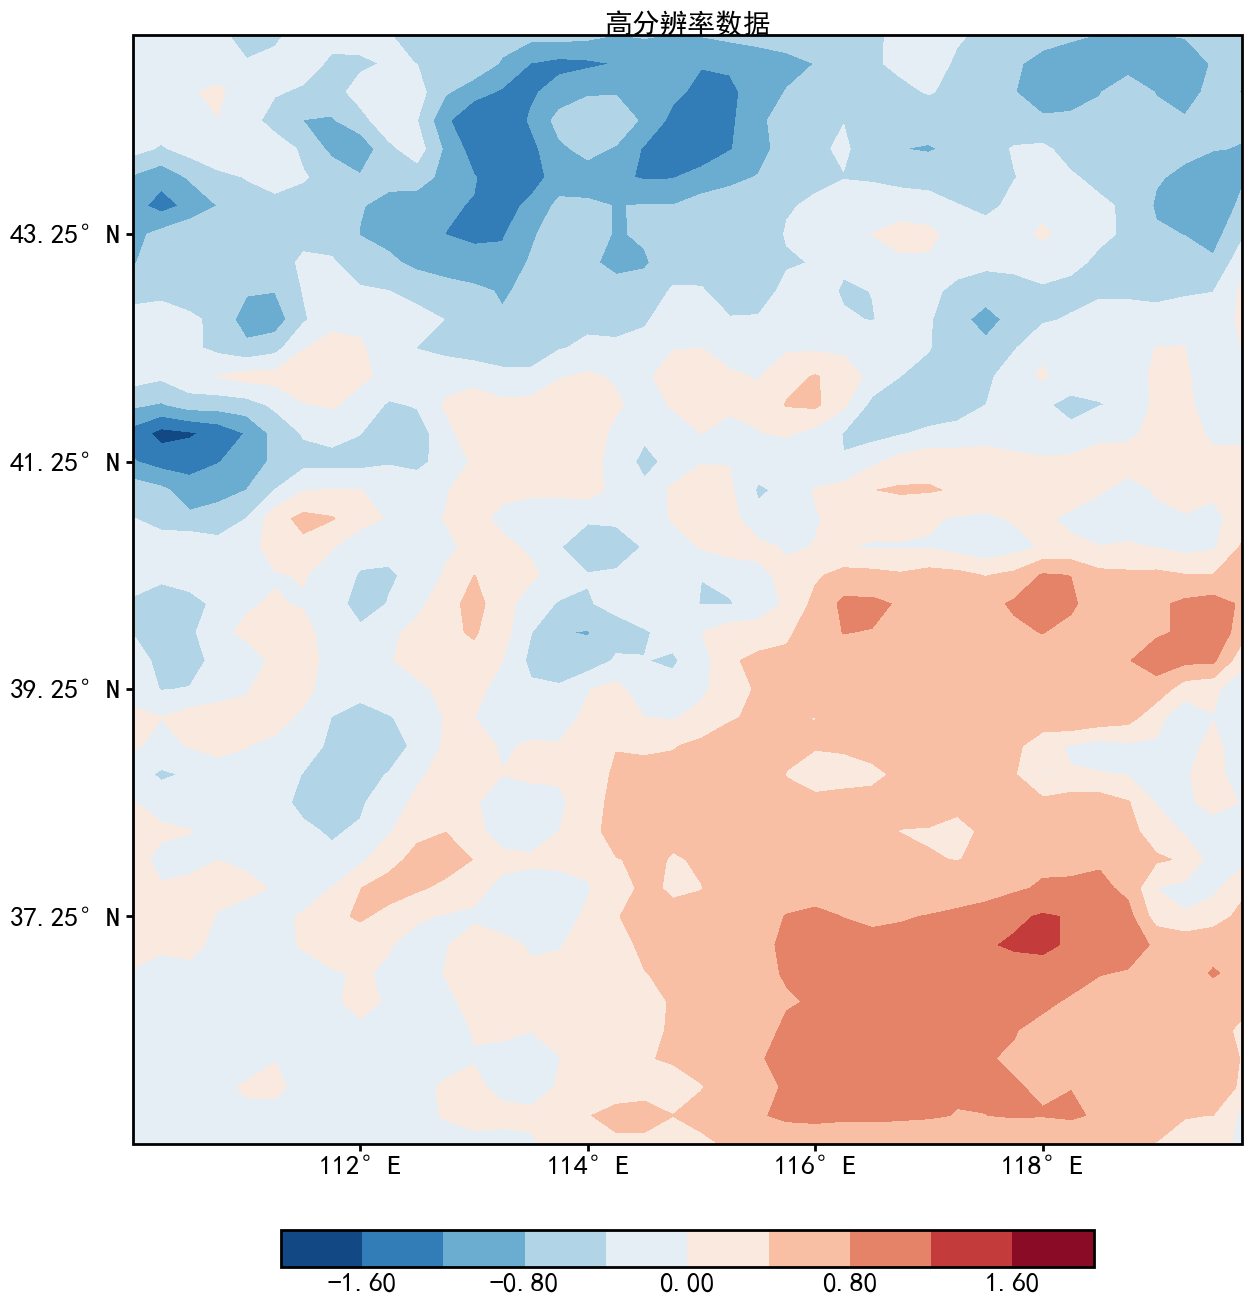

<Figure size 640x480 with 0 Axes>

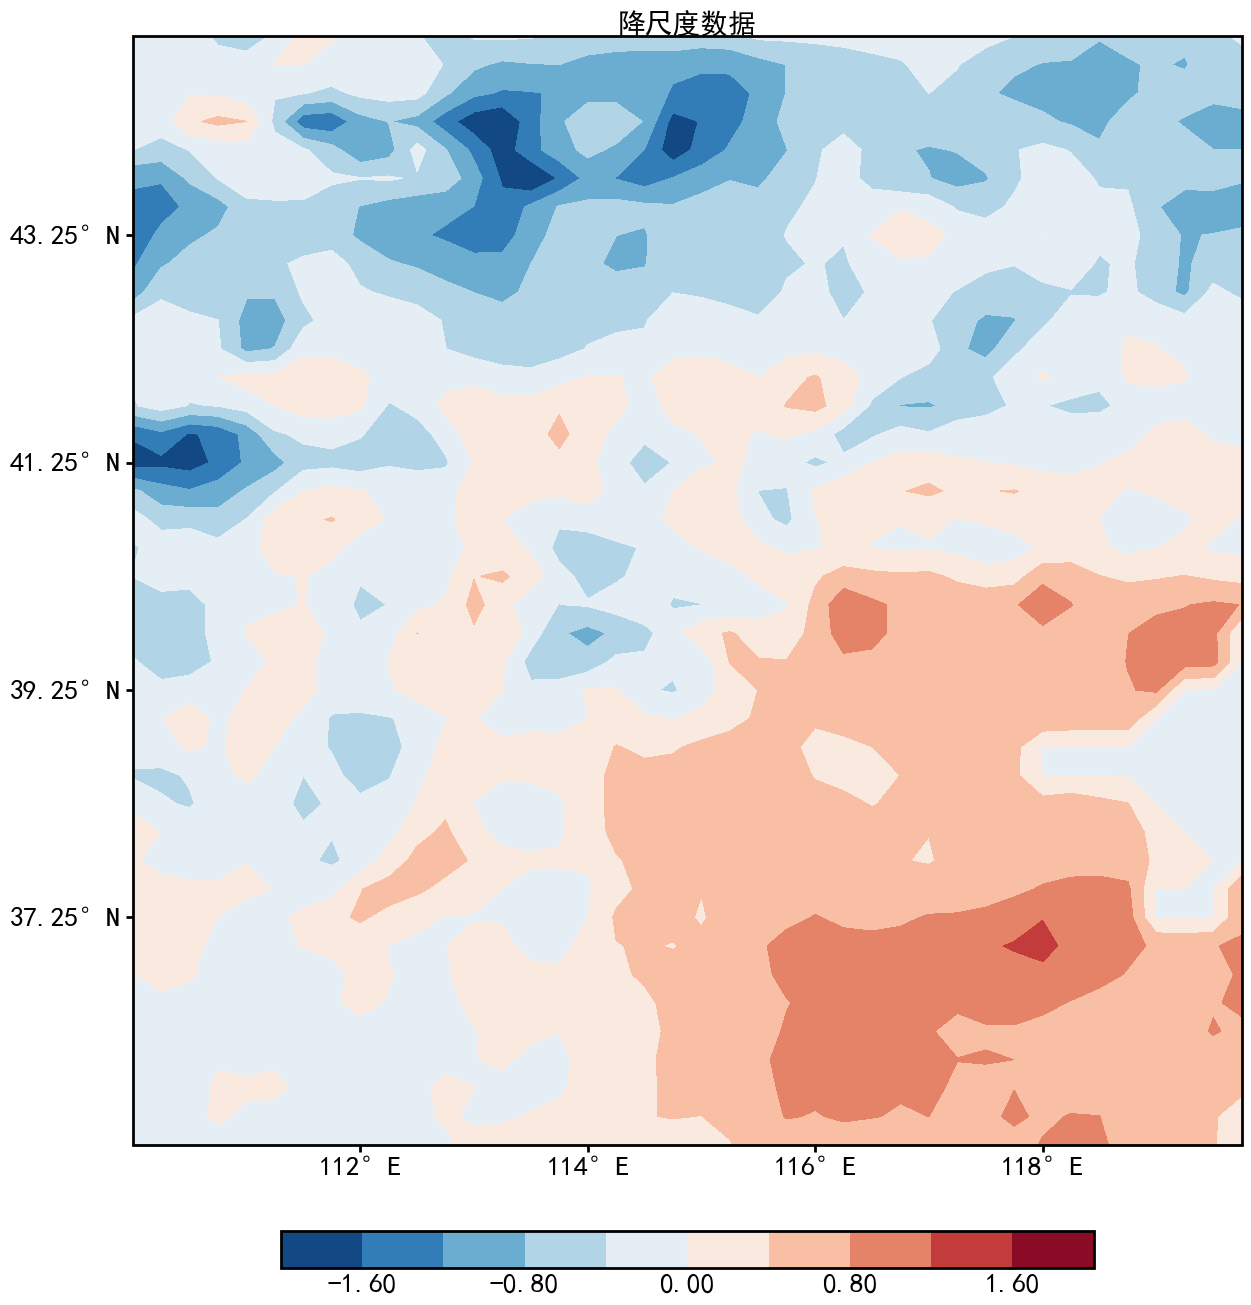

<Figure size 640x480 with 0 Axes>

In [8]:
import Auto_paint_self
Auto_paint_self.Autoshaded_quiver(testy[0,:,:],None,None,None,lon,lat,None,None,latlow,lattop,lonleft,lonright,'shaded','xy',picturenum=1,row=1,column=1,dpi=600,shadedcolor=None,ifshp='no',shpname=None,ifsave='no',savename=None,valuemodel='+-',ifself_vmax_vmin='yes',selfvmax =2.0,selfvmin=-2.0,shaded_quiver_title='高分辨率数据',ifline='no',ifclabel='no',ifcolorbar='yes',ifhatch='no',hatchpoint=None,hatchvalue=None,quiverscale=1,xspace=2,yspace=2,zspace=10000,labelsize=20,section=10.0,ifmaskout='no',maskoutarea=None,iftangle='no',tangle=None,ifchina='no',chinamap=None,ifsouthseamap='no',southseamap=None,southsealoc=[0.8, 0.21, 0.1, 0.15],ifglobal='no',projection_mode='plate',ifgridline='no',ifgeo='no',geo=None)
Auto_paint_self.Autoshaded_quiver(predicty[0,:,:],None,None,None,lon,lat,None,None,latlow,lattop,lonleft,lonright,'shaded','xy',picturenum=1,row=1,column=1,dpi=600,shadedcolor=None,ifshp='no',shpname=None,ifsave='no',savename=None,valuemodel='+-',ifself_vmax_vmin='yes',selfvmax =2.0,selfvmin=-2.0,shaded_quiver_title='降尺度数据',ifline='no',ifclabel='no',ifcolorbar='yes',ifhatch='no',hatchpoint=None,hatchvalue=None,quiverscale=1,xspace=2,yspace=2,zspace=10000,labelsize=20,section=10.0,ifmaskout='no',maskoutarea=None,iftangle='no',tangle=None,ifchina='no',chinamap=None,ifsouthseamap='no',southseamap=None,southsealoc=[0.8, 0.21, 0.1, 0.15],ifglobal='no',projection_mode='plate',ifgridline='no',ifgeo='no',geo=None)